# Homework 2 /Q2 : Building a network with Equinox and loss function with optax

## Imports for code

In [1]:
import equinox as eqx
import optax
import torch
import jax
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from jax import numpy as jnp
import numpy as np



## Loading MNIST

In [2]:
## Leveraging the Preproccesing in mnist_jax code
class JAXBatchLoader:
    def __init__(self, torch_loader, one_hot=False, num_classes=10, flatten=False):
        self.loader = torch_loader
        self.one_hot = one_hot
        self.num_classes = num_classes
        self.flatten = flatten
        self._iter = iter(torch_loader)

    def __iter__(self):
        self._iter = iter(self.loader)
        return self

    def __next__(self):
        images, labels = next(self._iter)
        images = images.numpy()  # shape: (batch, 1, 28, 28)
        labels = labels.numpy()
        images = images.squeeze(1)  # shape: (batch, 28, 28), normalize
        # images = images.squeeze(1) / 255.0  # shape: (batch, 28, 28), normalize
        if self.flatten:
            images = images.reshape(images.shape[0], -1)  # (batch, 784)
        if self.one_hot:
            labels = jnp.eye(self.num_classes)[labels]
        return jnp.array(images), jnp.array(labels)

def load_data(batch_size=64, shuffle=True, flatten=False, *, one_hot=False, num_classes=10):
    train_data = datasets.MNIST(root="data", train=True,  download=True, transform=ToTensor())
    test_data  = datasets.MNIST(root="data", train=False, download=True, transform=ToTensor())
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=shuffle)
    test_loader  = DataLoader(test_data,  batch_size=batch_size, shuffle=False)
    return (
        JAXBatchLoader(train_loader, one_hot=one_hot, num_classes=num_classes, flatten=flatten),
        JAXBatchLoader(test_loader,  one_hot=one_hot, num_classes=num_classes, flatten=flatten),
    )

## Creating Module with equinox

In [3]:
from typing import Sequence,List
class Classifier_MNIST(eqx.Module):
    #Linear conceptually most straightforward
    layers: List[eqx.nn.Linear]
    def __init__(self,sizes:Sequence[int],key):
        """
        sizes: e.g., [n_in, h1, h2, ..., n_out]
        """
        assert len(sizes) >= 2, "Need at least input and output sizes."
        keys = jax.random.split(key, len(sizes) - 1)

        self.layers = [
            eqx.nn.Linear(sizes[i], sizes[i+1], key=keys[i])
            for i in range(len(sizes) - 1)
        ]

    def __call__(self, x: jnp.ndarray) -> jnp.ndarray:
        if x.ndim == 1:
            for layer in self.layers:
                x = layer(x)           # vector OK
            return x
        else:
            for layer in self.layers:
                x = jax.vmap(layer)(x) # map layer over batch
            return x


## Using Optax for loss function and optimizers

In [4]:

def loss_fn(model, xb, yb, *, one_hot=False):
    """
    xb: (B, in)
    yb: (B,) if one_hot=False, or (B, num_classes) if one_hot=True
    """
    logits = model(xb)

    if one_hot:
        # when labels are already one-hot encoded
        return optax.softmax_cross_entropy(logits, yb).mean()
    else:
        # when labels are integer class indices
        return optax.softmax_cross_entropy_with_integer_labels(logits, yb).mean()


# Make a train_step that "remembers" the label style
def make_train_step(optimizer, *, one_hot: bool = False):
    value_and_grad = eqx.filter_value_and_grad(
        lambda m, xb, yb: loss_fn(m, xb, yb, one_hot=one_hot)
    )

    @eqx.filter_jit
    def train_step(model, opt_state, xb, yb):
        loss, grads = value_and_grad(model, xb, yb)
        updates, opt_state = optimizer.update(grads, opt_state, model)
        model = eqx.apply_updates(model, updates)
        return model, opt_state, loss
    return train_step

# Evaluation that works for both integer and one-hot labels
def evaluate(model, loader, *, one_hot: bool = False):
    correct, total = 0, 0
    for xb, yb in loader:
        logits = model(xb)
        pred = jnp.argmax(logits, axis=-1)
        y_true = jnp.argmax(yb, axis=-1) if one_hot else yb
        correct += int((pred == y_true).sum())
        total   += int(y_true.shape[0])
    return correct / total


In [5]:
# sizes for MNIST:
# sizes = [784, 128, 30, 10]
# sizes = [784, 128, 10]
sizes = [784, 30, 10]
#sizes = [784, 1024, 64, 10]

key = jax.random.PRNGKey(0)
model = Classifier_MNIST(sizes, key=key)


# ---- choose your label style to match your loader ----
use_one_hot = False     # True if you loaded with one_hot=True

# loaders: integer labels (works with integer-label cross-entropy)
train_loader, test_loader = load_data(batch_size=128, flatten=True, one_hot=use_one_hot)



# ---- optimizer + train_step ----
optimizer  = optax.sgd(0.1)
opt_state  = optimizer.init(model)
train_step = make_train_step(optimizer, one_hot=use_one_hot)

# ----  training loop (e.g., 3 to match the part A code) ----
epochs = 3
for ep in range(1, epochs + 1):
    losses = []
    for xb, yb in train_loader:
        # ensure label shapes: (B,) for int or (B,10) for one-hot
        if use_one_hot:
            assert yb.ndim == 2, f"Expected one-hot labels (B,10); got {yb.shape}"
        else:
            if yb.ndim == 2 and yb.shape[-1] == 1:
                yb = yb.squeeze(-1)  # (B,1) -> (B,)
            assert yb.ndim == 1, f"Expected integer labels (B,); got {yb.shape}"

        model, opt_state, l = train_step(model, opt_state, xb, yb)
        losses.append(float(l))

    tr_acc = evaluate(model, train_loader, one_hot=use_one_hot)
    te_acc = evaluate(model, test_loader,  one_hot=use_one_hot)
    print(f"Epoch {ep:02d} | loss={np.mean(losses):.4f} | train_acc={tr_acc:.4f} | test_acc={te_acc:.4f}")


Epoch 01 | loss=0.5515 | train_acc=0.9036 | test_acc=0.9082
Epoch 02 | loss=0.3239 | train_acc=0.9131 | test_acc=0.9174
Epoch 03 | loss=0.3023 | train_acc=0.9152 | test_acc=0.9174


2

Plot the W2 weights

The weights into h0 have image


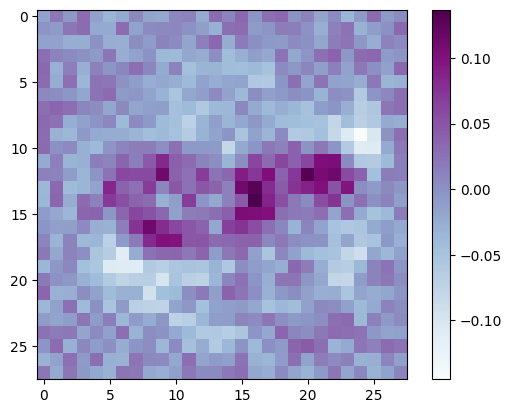


The weights into h1 have image


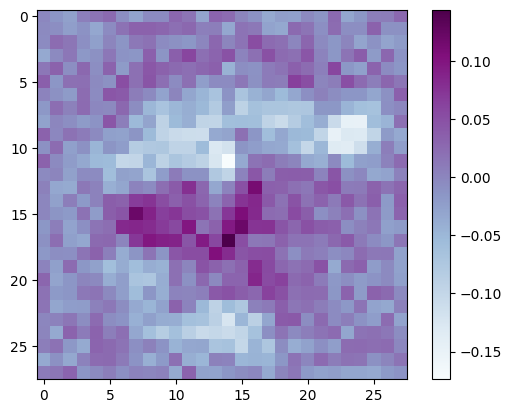


The weights into h2 have image


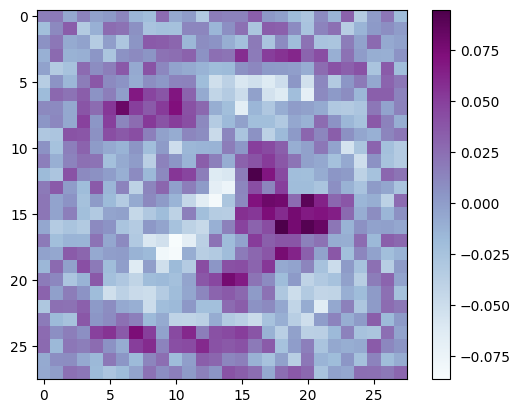


The weights into h3 have image


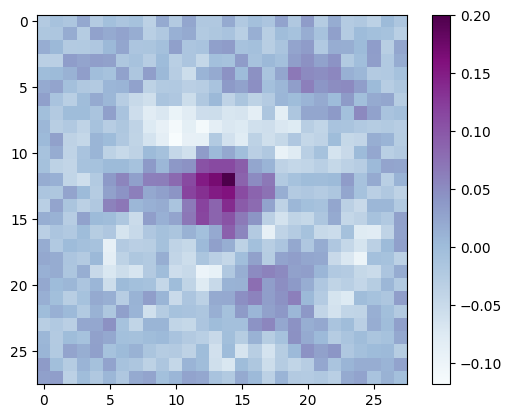


The weights into h4 have image


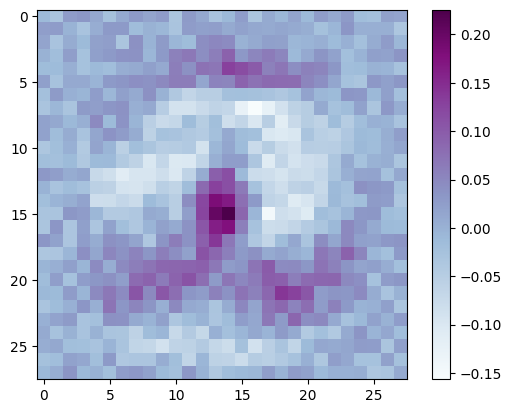


The weights into h5 have image


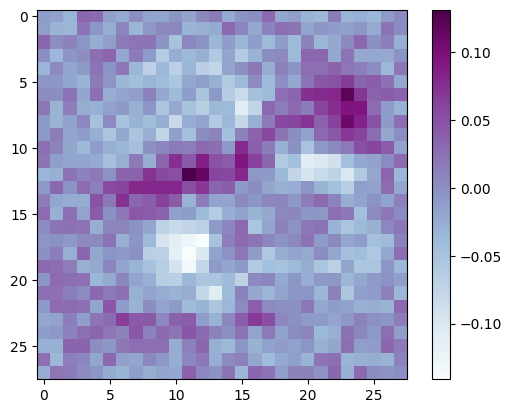


The weights into h6 have image


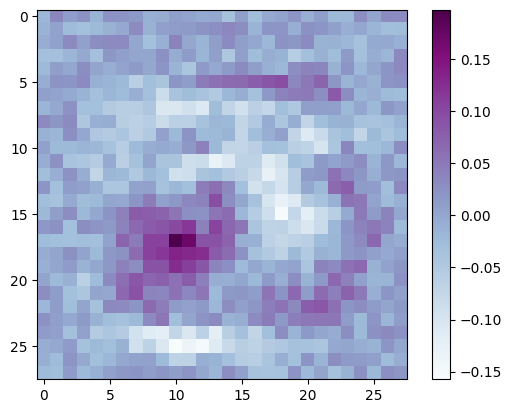


The weights into h7 have image


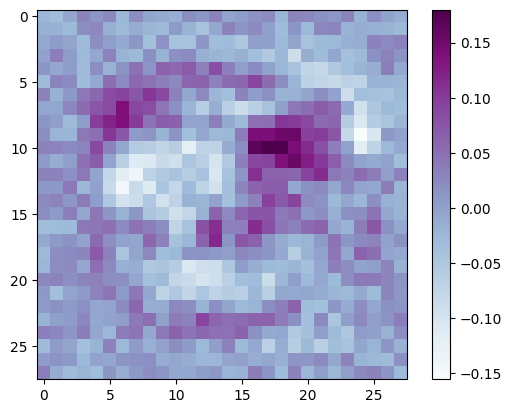


The weights into h8 have image


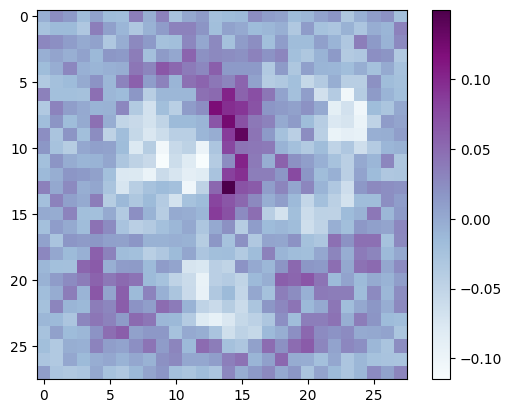


The weights into h9 have image


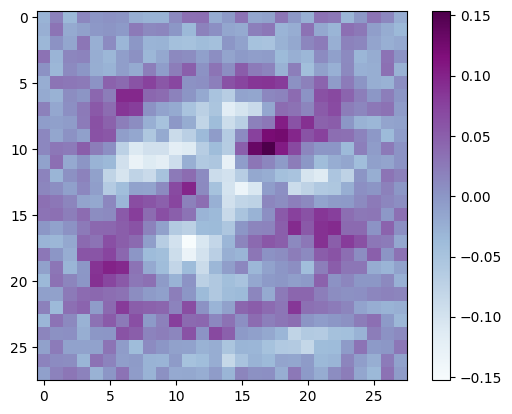


The weights into h10 have image


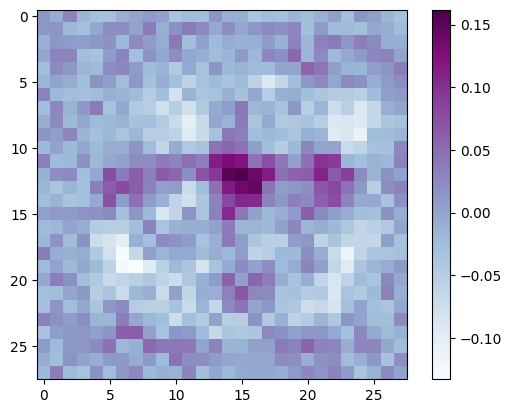


The weights into h11 have image


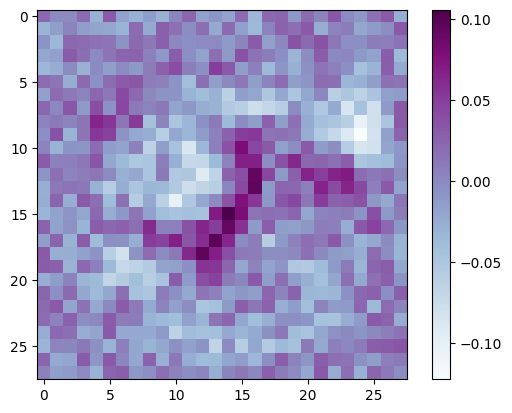


The weights into h12 have image


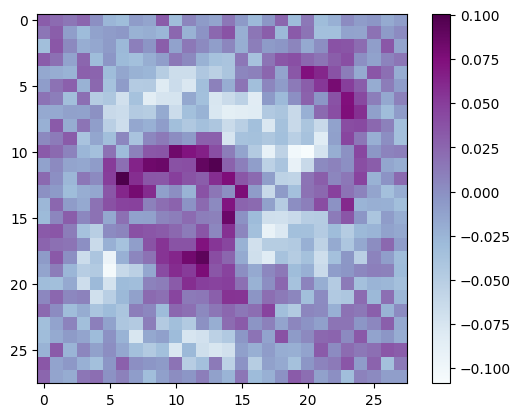


The weights into h13 have image


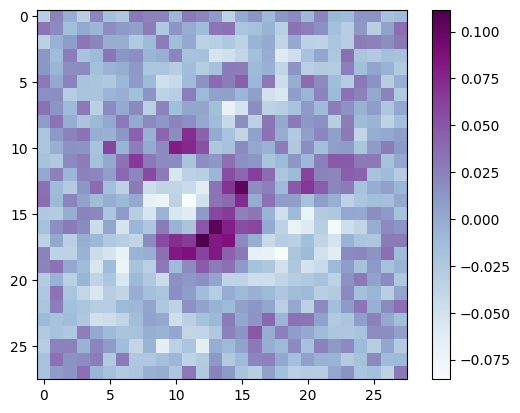


The weights into h14 have image


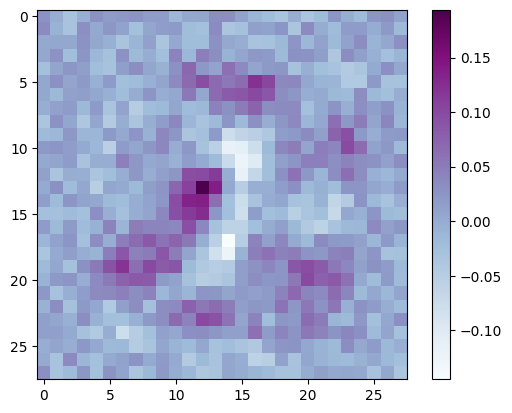


The weights into h15 have image


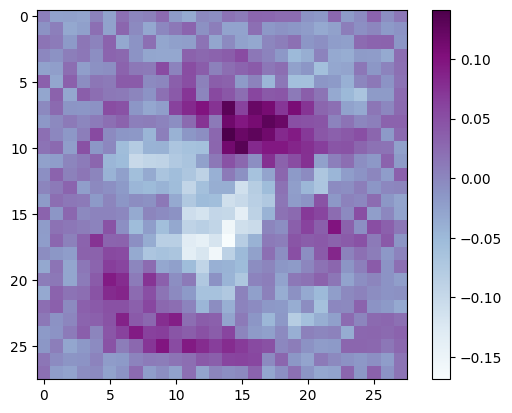


The weights into h16 have image


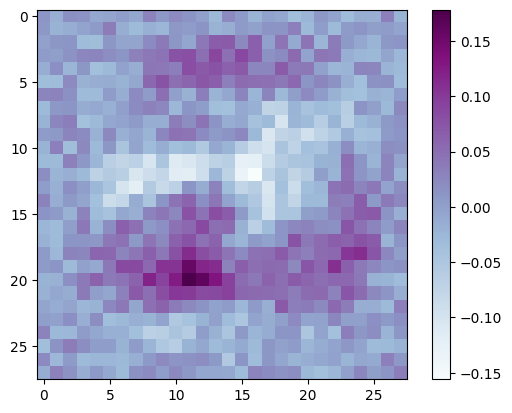


The weights into h17 have image


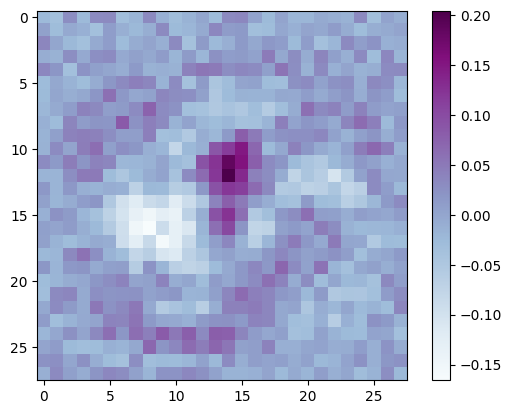


The weights into h18 have image


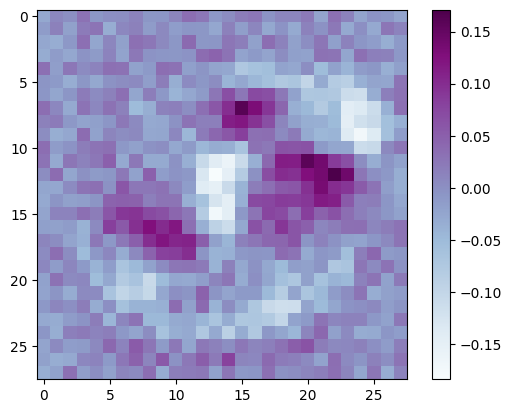


The weights into h19 have image


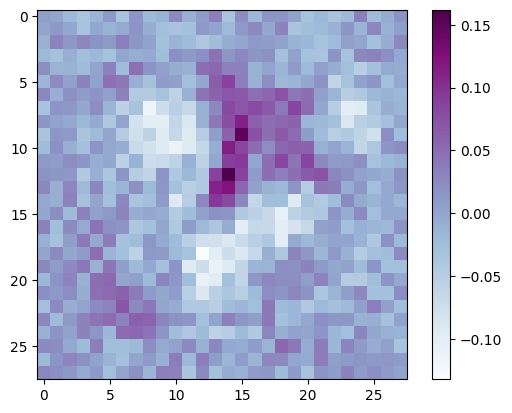


The weights into h20 have image


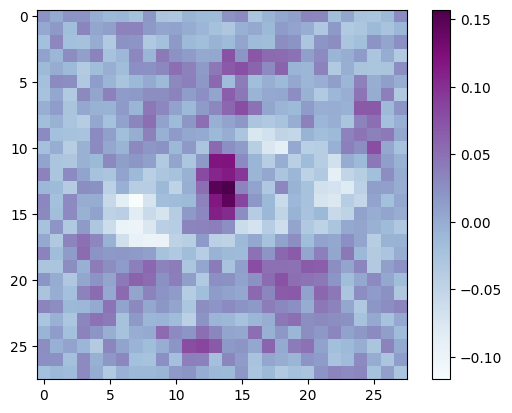


The weights into h21 have image


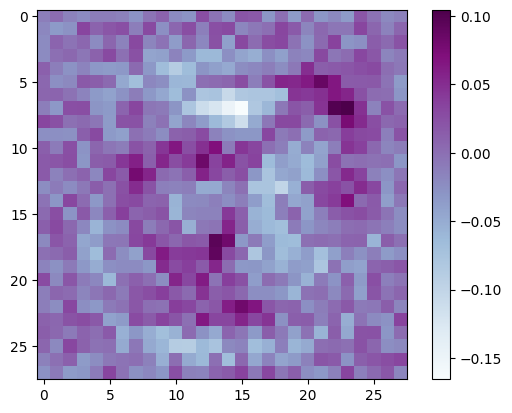


The weights into h22 have image


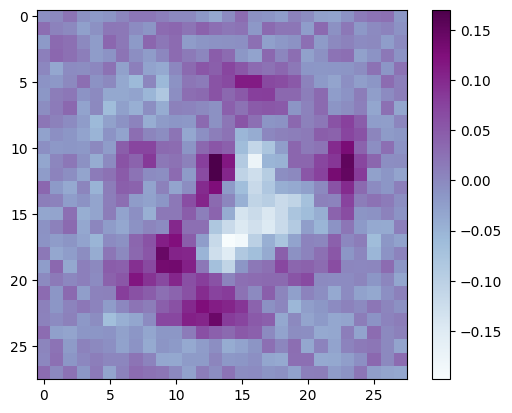


The weights into h23 have image


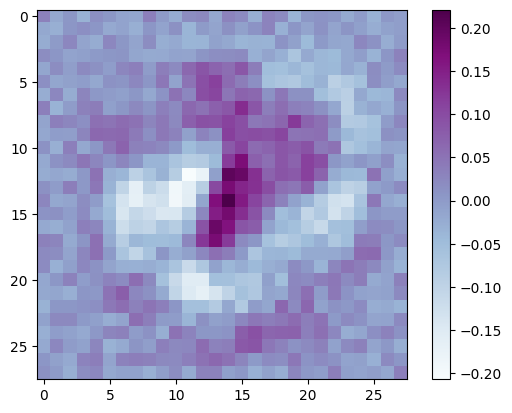


The weights into h24 have image


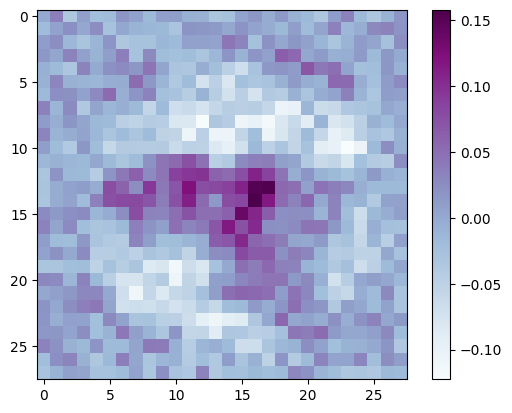


The weights into h25 have image


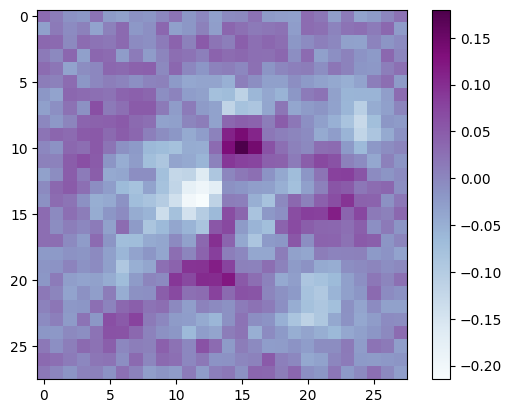


The weights into h26 have image


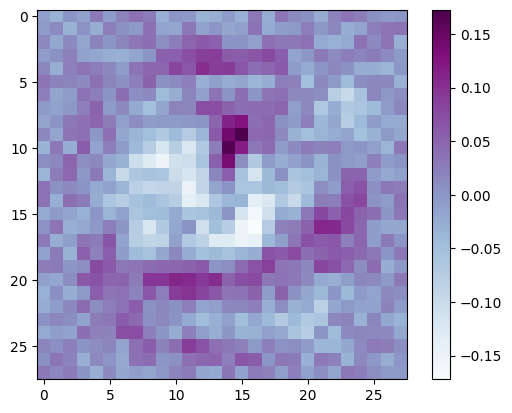


The weights into h27 have image


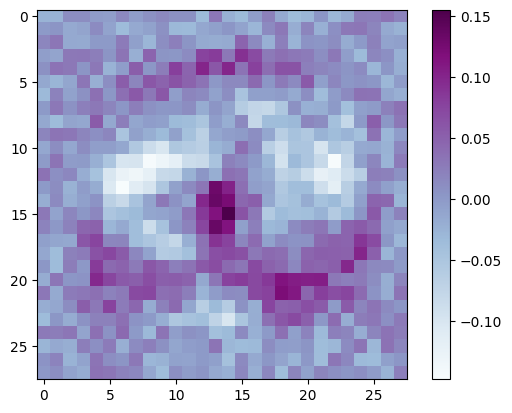


The weights into h28 have image


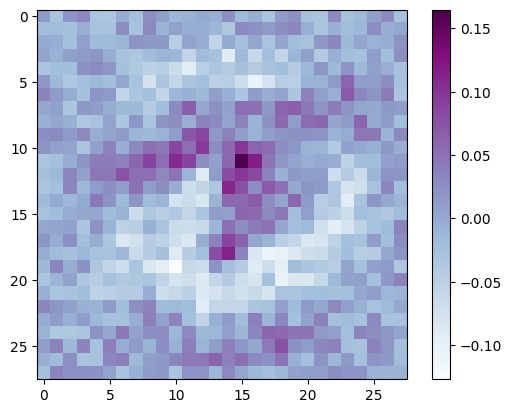


The weights into h29 have image


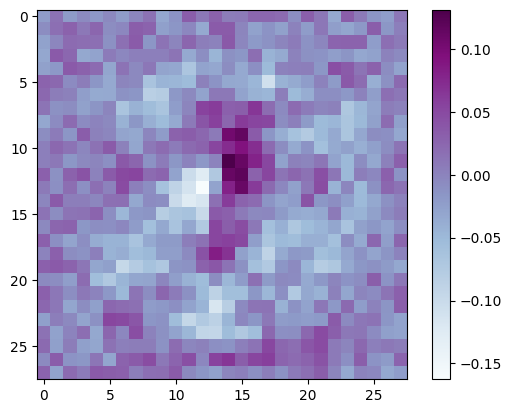


Plot the W3 weights.
The weights into output 0 are


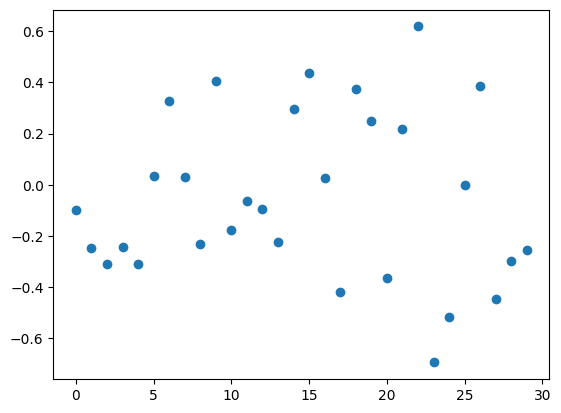

The weights into output 1 are


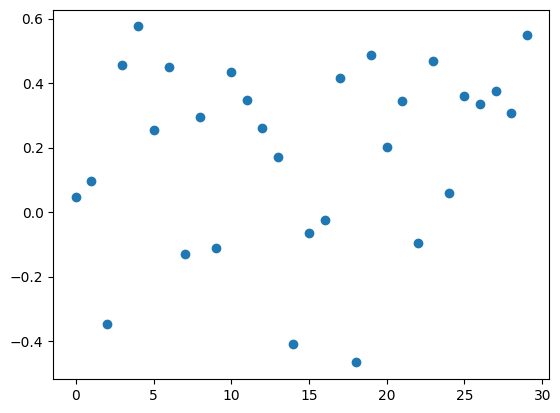

The weights into output 2 are


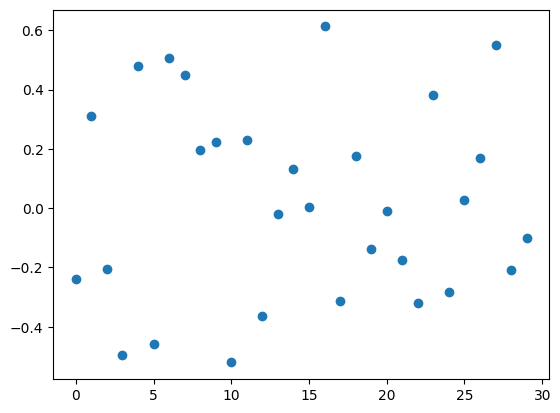

The weights into output 3 are


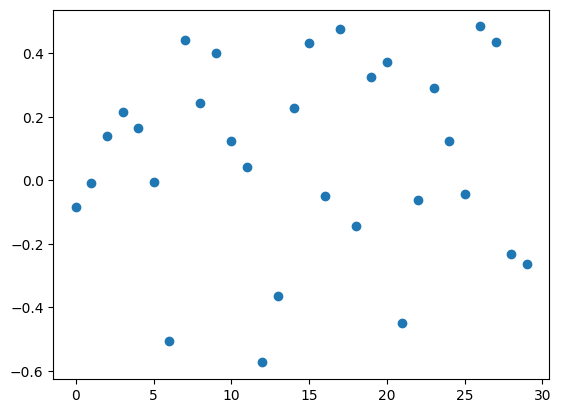

The weights into output 4 are


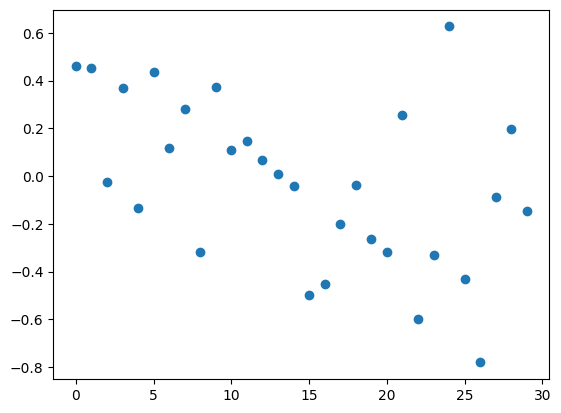

The weights into output 5 are


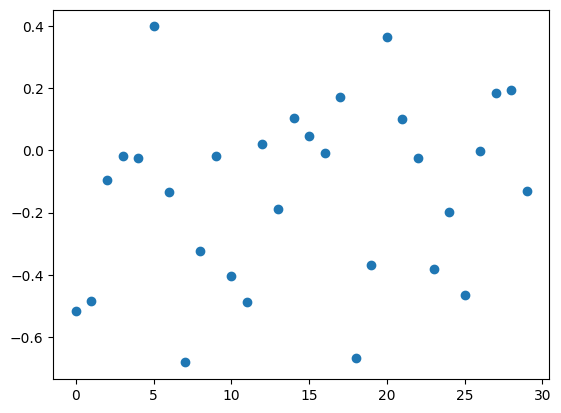

The weights into output 6 are


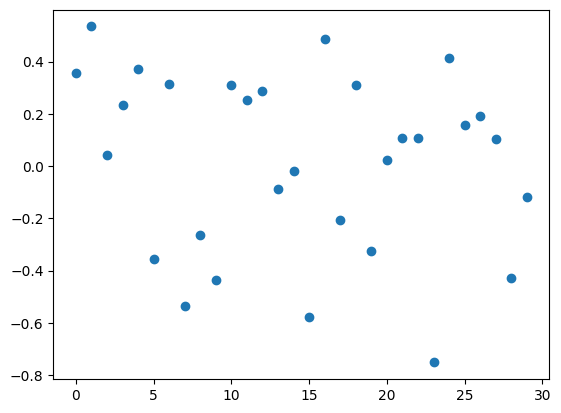

The weights into output 7 are


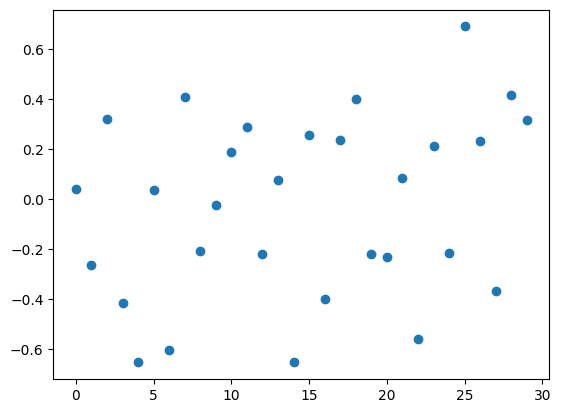

The weights into output 8 are


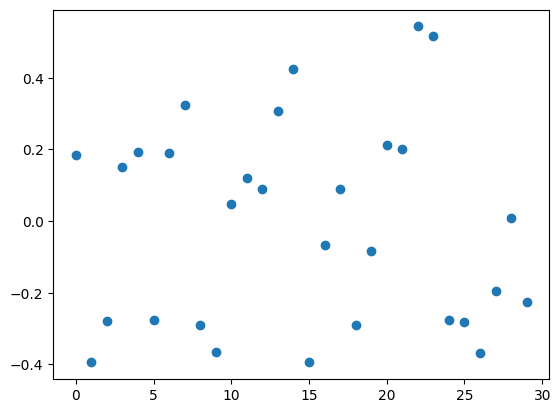

The weights into output 9 are


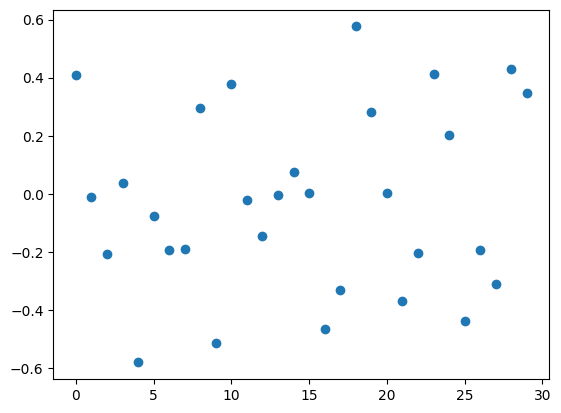

In [6]:
import matplotlib.pyplot as plt
import numpy as np
print(len(model.layers))

# Layer 1 = input layer;
# Layer 2 weights (input -> hidden),
W2 = np.array(model.layers[0].weight)   # (hidden, 784)

print("\nPlot the W2 weights")
for j in range(W2.shape[0]):            # hidden size (e.g., 30 or 128)
    h_image = W2[j].reshape(28, 28)
    print(f"\nThe weights into h{j} have image")
    plt.imshow(h_image, cmap='BuPu', origin='upper')
    plt.colorbar()
    plt.show()

# Layer 3 weights (hidden -> output), "
W3 = np.array(model.layers[1].weight)   # (10, hidden)

print("\nPlot the W3 weights.")
for j in range(W3.shape[0]):            # 10 outputs
    print(f"The weights into output {j} are")
    plt.plot(W3[j], 'o')
    plt.show()
